In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import statistics as stats
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint

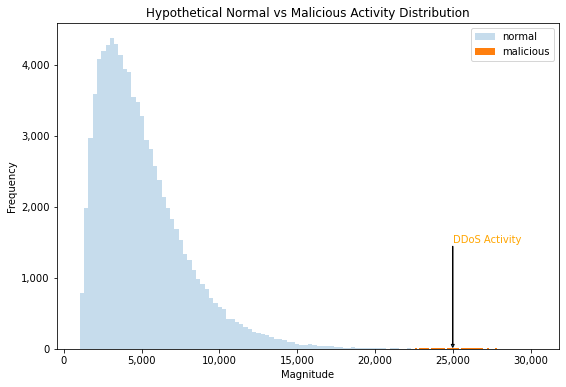

In [2]:
# Assume that we are performing a retrospective after a DoS attack occurred on a webserver.
# Our objective is to understand how to set thresholds on a quantitative signal 


# Each observation is the magnitude of an attack indicator (ports open, bandwidth) in a one-minute window.
# (using this as a stand-in for any quantitative measure to be used as a threshold)

# https://www.techspot.com/news/78661-ddos-attacks-dropped-13-percent-last-year-but.html
# in 2018, Kaspersky reported an avg DDoS duration of 218 minutes.
# Let's use 300 (5 hours) as a hypothetical, assuming an increase in duration since then.
np.random.seed(6)
malicious_traffic = np.random.normal(loc=25000, scale=2000, size=300)

# Let's assume that the company is expecting a DDos attack once ever two months
# and that traffic patterns are not perfectly in a bell-curve;
# There will be a long tail towards the right to represent anomalous (high)
# but not malicious activity.
normal_traffic = [i + 1000 for i in np.random.gamma(shape=2, scale=2000, size=86100)]

fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(9, 6)
plt.hist(normal_traffic, bins=100, alpha=.25, label='normal')
plt.hist(malicious_traffic, bins=100, label='malicious')
plt.title('Hypothetical Normal vs Malicious Activity Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.legend()
plt.annotate('DDoS Activity', xy=(25000,20), 
             xytext=(25000,1500), color='orange',
            arrowprops=dict(width=.25, headlength=3, headwidth=3))
plt.show()

# As you can see below, the malicious "observations" are very rare (though high magnitude) 
# compared to the rest of the observations from that period.

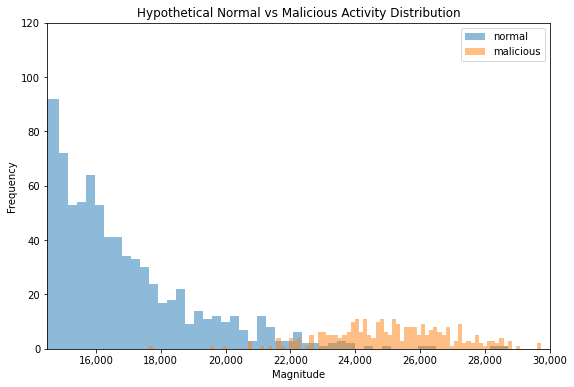

In [3]:
# Let's zoom in on the overlap for clarity.
# The lower range of the DDoS distribution overlaps with the highest range of the normal traffic.
# This is to illustrate that non-malicious activity can "look" the same and produce
# the same effects - lack of capacity during a huge sale could make a site implode.

fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(9, 6)
plt.hist(normal_traffic, bins=100, alpha=.5, label='normal')
plt.hist(malicious_traffic, bins=100, alpha=.5, label='malicious')
plt.title('Hypothetical Normal vs Malicious Activity Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.xlim(14500,30000)
plt.ylim(0,120)
plt.legend()
plt.show()

In [4]:
# The general statistics rule of thumb is to use a threshold of
# avg + (3 * standard deviation); anything above that is generally an outlier.
# How does this play out for our dataset?

normal_mean = stats.mean(normal_traffic)
normal_stdev = stats.stdev(normal_traffic)
threshold = normal_mean + (3 * normal_stdev)

print(f'The mean is approximately {int(normal_mean)}.')
print(f'The stdev is approximately {int(normal_stdev)}.')
print(f'Let\'s classify everything above {int(threshold)} as anomalous.')

The mean is approximately 5015.
The stdev is approximately 2843.
Let's classify everything above 13545 as anomalous.


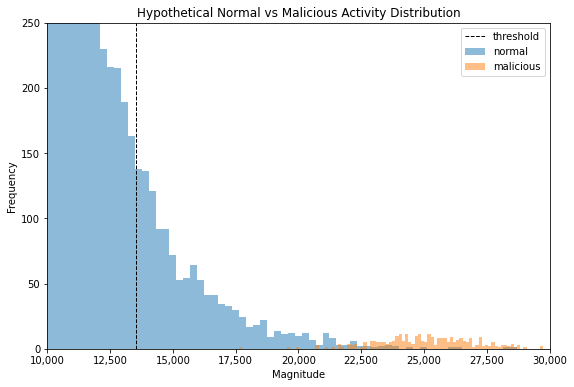

In [5]:
fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(9, 6)
plt.hist(normal_traffic, bins=100, alpha=.5, label='normal')
plt.hist(malicious_traffic, bins=100, alpha=.5, label='malicious')
plt.title('Hypothetical Normal vs Malicious Activity Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.xlim(10000,30000)
plt.ylim(0,250)
plt.axvline(x=threshold, color='k', linestyle='dashed', linewidth=1, label='threshold')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.legend()
plt.show()

# While we do capture all the malicious activity, we also have a ton of false positives.
# Even if we were to dedupe alerts on a window of time, an analyst would end up wasting a fair amount
# of time validating the false positives (though a different threat actor may happen to DoS at a lower range).

In [6]:
# A major contribution to this problem is the fact that our traffic is not "normally" distributed
# If we check the median of the normal activity, we will find that it is significantly lower 
# than the average because of the skew from the long tail.

normal_median = stats.median(normal_traffic)
delta = (normal_mean - normal_median) / normal_stdev
print(f'The median is approximately {int(normal_median)} and it is {round(delta,2)} standard deviations away from the mean ({int(normal_mean)}).')

# We may want to consider using calculations centered around the median, to control for skew.
# However, it may not be feasible to construct this metric in Splunk or another SIEM.

The median is approximately 4372 and it is 0.23 standard deviations away from the mean (5015).


In [7]:
# Based on this threshold, let's see our "confusion matrix"

true_positives = len([i for i in malicious_traffic if i >= threshold])
false_negatives = len(malicious_traffic) - true_positives
false_positives = len([i for i in normal_traffic if i >= threshold])
true_negatives = len(normal_traffic) - false_positives
print(f'{true_positives} TP (detected DoS) and {false_negatives} FN (undetected DoS)')
print(f'{false_positives} FP (mistook normal traffic for DoS) and {true_negatives} TN (correctly ID\'ed normal traffic)')

300 TP (detected DoS) and 0 FN (undetected DoS)
1229 FP (mistook normal traffic for DoS) and 84871 TN (correctly ID'ed normal traffic)


In [8]:
# What do our evaluation metrics tell us?

# Accuracy = (TP+TN)/(TP+FN+FP+TN)
# How often were we right?
accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + false_positives + true_negatives)
print(f'Accuracy: {round(accuracy * 100,4)}%')
# Seems pretty good, but this is due to sparseness of positives. 
# We could ignore all values and still be very "accurate".
print(f'No threshold accuracy: {round(true_negatives  / (true_positives + false_negatives + false_positives + true_negatives) * 100,4)}%')

# Precision = (TP)/(TP+FP) 
# Pretty key for our needs - want to avoid false positives if we can
precision = (true_positives) / (true_positives + false_positives)
print(f'Precision: {round(precision * 100,4)}%')
# Terrible due to the amount of false positives - will waste a lot of resources

# Recall = (TP)/(TP+FN)
# How many of the DoS observations are we catching?
recall = (true_positives) / (true_positives + false_negatives)
print(f'Recall: {round(recall * 100,4)}%')
# Excellent due to our kitchen sink methodology, at the expense of precision

# F1 = 2 * (precision * recall) / (precision + recall)
# harmonic mean of precision and recall
f1_score = 2 * (precision * recall) / (precision + recall)
print(f'F1 Score: {round(f1_score * 100,4)}%')
# Perhaps our better objective function if we want to balance precision and recall
# we can weight it more heavily against recall if false negatives are more expensive.

Accuracy: 98.5775%
No threshold accuracy: 98.2303%
Precision: 19.6207%
Recall: 100.0%
F1 Score: 32.8048%


In [9]:
# Let's put ourselves in the shoes of a lone SOC analyst without much statistical background
# They've read the case study and recommendations in the Splunk forum, but find themselves
# annoyed with the amount of false positives. They can manually inch the threshold back and forth,
# but there may be a fine line between wasting time and missing an expensive attack.
# Can we help them simulate the results of manual tuning to narrow down on a range that might work?

# Create a list of incrementally higher multipliers to be used in the threshold calculation.

multipliers = []
for i in range(50):
    multipliers.append(round(3 + (i * .1),1))
print(multipliers)
print('\n')

# Iterate over the multipliers to calculate the thresholds and evaluation metrics.

evaluations = {}
for multiplier in multipliers:
    threshold = normal_mean + (normal_stdev * multiplier)
    true_positives = len([i for i in malicious_traffic if i >= threshold])
    false_negatives = len(malicious_traffic) - true_positives
    false_positives = len([i for i in normal_traffic if i >= threshold])
    true_negatives = len(normal_traffic) - false_positives
    
    precision = (true_positives) / (true_positives + false_positives)
    recall = (true_positives) / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    evaluations[multiplier] = {
        'threshold':int(threshold),
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'precision': round(precision,4),
        'recall': round(recall,4),
        'f1_score': round(f1_score,4),
    }

pprint(evaluations)

[3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9]


{3.0: {'f1_score': 0.328,
       'false_negatives': 0,
       'false_positives': 1229,
       'precision': 0.1962,
       'recall': 1.0,
       'threshold': 13545},
 3.1: {'f1_score': 0.3563,
       'false_negatives': 0,
       'false_positives': 1084,
       'precision': 0.2168,
       'recall': 1.0,
       'threshold': 13829},
 3.2: {'f1_score': 0.3861,
       'false_negatives': 0,
       'false_positives': 954,
       'precision': 0.2392,
       'recall': 1.0,
       'threshold': 14113},
 3.3: {'f1_score': 0.4152,
       'false_negatives': 0,
       'false_positives': 845,
       'precision': 0.262,
       'recall': 1.0,
       'threshold': 14398},
 3.4: {'f1_score': 0.4451,
       'false_negatives': 0,
       'false_positives': 748,


In [10]:
eval_df = pd.DataFrame.from_dict(evaluations, orient='index').reset_index().rename(columns={'index':'multiplier'})
eval_df.head()

,multiplier,threshold,false_positives,false_negatives,precision,recall,f1_score
0,3.0,13545,1229,0,0.1962,1.0,0.3280
1,3.1,13829,1084,0,0.2168,1.0,0.3563
2,3.2,14113,954,0,0.2392,1.0,0.3861
3,3.3,14398,845,0,0.2620,1.0,0.4152
4,3.4,14682,748,0,0.2863,1.0,0.4451


In [11]:
eval_df.to_csv('simulation_scores.csv')

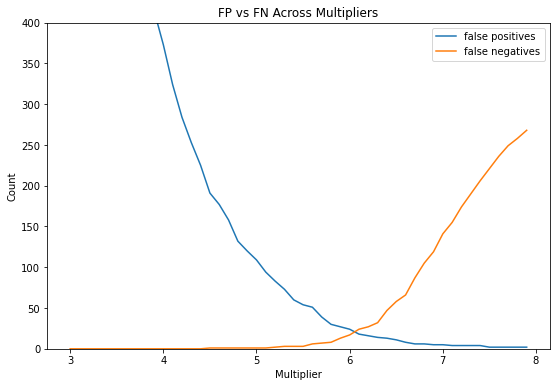

In [12]:
# Let's map the changes in false positives vs false negatives as the multiplier changes

fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(9, 6)
sns.lineplot(x='multiplier', y='false_positives', data=eval_df, label='false positives')
sns.lineplot(x='multiplier', y='false_negatives', data=eval_df, label='false negatives')
plt.ylabel('Count')
plt.xlabel('Multiplier')
plt.title('FP vs FN Across Multipliers')
plt.ylim(0,400)
plt.legend()
plt.show()

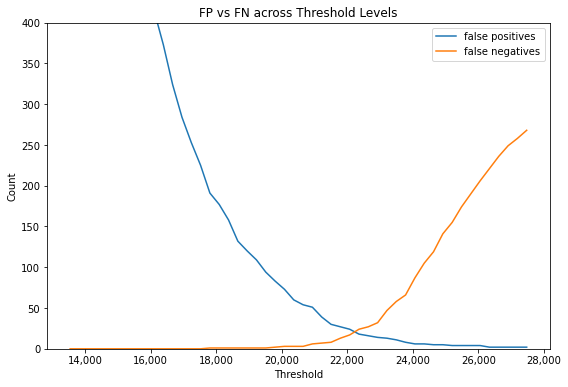

In [13]:
# Another one using threshold

fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(9, 6)
sns.lineplot(x='threshold', y='false_positives', data=eval_df, label='false positives')
sns.lineplot(x='threshold', y='false_negatives', data=eval_df, label='false negatives')
plt.ylabel('Count')
plt.xlabel('Threshold')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('FP vs FN across Threshold Levels')
plt.ylim(0,400)
plt.show()

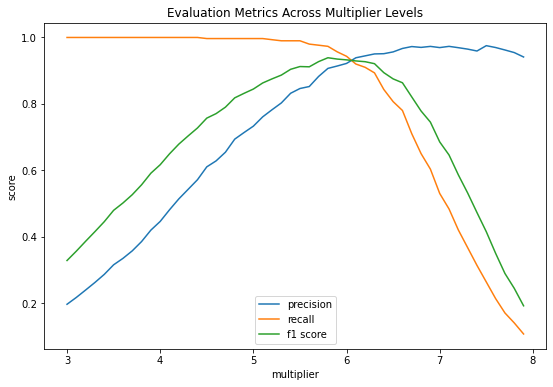

In [14]:
# Let's plot our evaluation metrics across multiplier values.

fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(9, 6)
sns.lineplot(x='multiplier', y='precision', data=eval_df, label='precision')
sns.lineplot(x='multiplier', y='recall', data=eval_df, label='recall')
sns.lineplot(x='multiplier', y='f1_score', data=eval_df, label='f1 score')
plt.ylabel('score')
plt.xlabel('multiplier')
plt.title('Evaluation Metrics Across Multiplier Levels')
plt.legend(loc='lower center')
plt.show()

In [15]:
# A recommended sweet spot for the analyst could be somewhere around where the F1 score is at its maximum.
# Note that we could tweak the f1 score calculation depending on our risk tolerance

f1_max = eval_df[eval_df.f1_score == eval_df.f1_score.max()]
f1_max

,multiplier,threshold,false_positives,false_negatives,precision,recall,f1_score
28,5.8,21506,30,8,0.9068,0.9733,0.9389


In [16]:
# At this point, the analyst is left with a more useful range to pick for thresholding.
# However, they may not have context of the relative costs of a false positive
# or false negative. Missing a FN may be much more expensive than the costs of investigating a FP.
# https://blog.radware.com/security/2013/05/how-much-can-a-ddos-attack-cost-your-business/

# Let's consider a hypothetical where the alert is deduplicated every 15 minutes to avoid overkill.
# The finance and IT teams have estimated that the cost for each error is:
# FP: $5000 inclusive of opportunity cost and cross-department resources
# FN: $75,000 of opportunity cost and triage resources
# Is there a cost-minimizing point we can identify with our simulation?

fp_cost = 5000
fn_cost = 75000
dedupe_min = 15
eval_df['fp_cost'] = (eval_df.false_positives / dedupe_min) * fp_cost
eval_df['fn_cost'] = (eval_df.false_negatives / dedupe_min) * fn_cost
eval_df['estimated_total_cost_thousands'] = (eval_df.fp_cost + eval_df.fn_cost) / 1000
eval_df.head()

,multiplier,threshold,false_positives,false_negatives,precision,recall,f1_score,fp_cost,fn_cost,estimated_total_cost_thousands
0,3.0,13545,1229,0,0.1962,1.0,0.3280,409666.666667,0.0,409.666667
1,3.1,13829,1084,0,0.2168,1.0,0.3563,361333.333333,0.0,361.333333
2,3.2,14113,954,0,0.2392,1.0,0.3861,318000.000000,0.0,318.000000
3,3.3,14398,845,0,0.2620,1.0,0.4152,281666.666667,0.0,281.666667
4,3.4,14682,748,0,0.2863,1.0,0.4451,249333.333333,0.0,249.333333


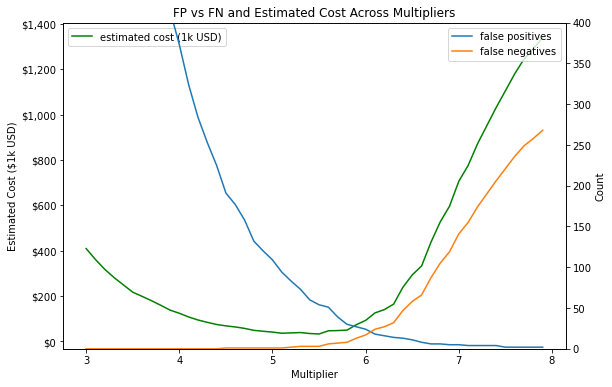

In [17]:
# Let's put it into context with our FN and FP counts

fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(9, 6)
sns.lineplot(x='multiplier', y='estimated_total_cost_thousands', data=eval_df, label='estimated cost (1k USD)', color='green', legend=False)
ax.set_ylabel('Estimated Cost ($1k USD)')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
ax.set_xlabel('Multiplier')

ax2 = ax.twinx()
sns.lineplot(x='multiplier', y='false_positives', ax=ax2, data=eval_df, label='false positives', legend=False)
sns.lineplot(x='multiplier', y='false_negatives', ax=ax2, data=eval_df, label='false negatives', legend=False)
ax2.set_ylabel('Count')
ax2.set_ylim(0,400)
plt.legend(loc='upper right')
ax.legend(loc='upper left')
plt.title('FP vs FN and Estimated Cost Across Multipliers')
plt.show()

# Here we can start to see the FN cost starting to outweigh the reduction in FP cost between 5-6 

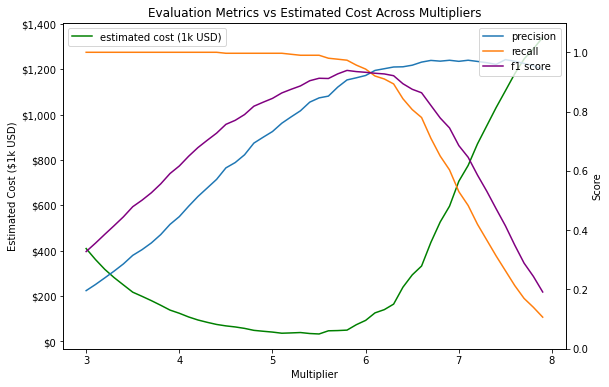

In [18]:
# Compare it to our evaluation metrics.

fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(9, 6)
sns.lineplot(x='multiplier', y='estimated_total_cost_thousands', data=eval_df, label='estimated cost (1k USD)', color='green', legend=False)
ax.set_ylabel('Estimated Cost ($1k USD)')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
ax.set_xlabel('Multiplier')

ax2 = ax.twinx()
sns.lineplot(x='multiplier', y='precision', ax=ax2, data=eval_df, label='precision', legend=False)
sns.lineplot(x='multiplier', y='recall', ax=ax2, data=eval_df, label='recall', legend=False)
sns.lineplot(x='multiplier', y='f1_score', ax=ax2, data=eval_df, label='f1 score', legend=False, color='purple')
ax2.set_ylabel('Score')
ax2.set_ylim(0,1.1)
plt.legend(loc='upper right')
ax.legend(loc='upper left')
plt.title('Evaluation Metrics vs Estimated Cost Across Multipliers')
plt.show()

# The cost minimization strategy suggests a slightly different threshold point.

In [19]:
cost_min = eval_df[eval_df.estimated_total_cost_thousands == eval_df.estimated_total_cost_thousands.min()]
cost_min

,multiplier,threshold,false_positives,false_negatives,precision,recall,f1_score,fp_cost,fn_cost,estimated_total_cost_thousands
25,5.5,20653,54,3,0.8462,0.99,0.9124,18000.0,15000.0,33.0


In [20]:
# Let's export our dataset as a csv to be used as a dummy input for our script.

normal_df = pd.DataFrame(normal_traffic).rename(columns={0:'magnitude'})
normal_df['record_type'] = 'normal'
normal_df['is_ddos'] = 0
normal_df.head()

,magnitude,record_type,is_ddos
0,3917.150671,normal,0
1,9379.403504,normal,0
2,1544.080967,normal,0
3,3403.995906,normal,0
4,4883.865333,normal,0


In [21]:
# Malicious traffic.

malicious_df = pd.DataFrame(malicious_traffic).rename(columns={0:'magnitude'})
malicious_df['record_type'] = 'DDoS'
malicious_df['is_ddos'] = 1
malicious_df.head()

,magnitude,record_type,is_ddos
0,24376.432653,DDoS,1
1,26458.007847,DDoS,1
2,25435.641576,DDoS,1
3,23201.816407,DDoS,1
4,20026.438697,DDoS,1


In [22]:
# Concat the dfs together.

dummy_data = pd.concat([normal_df, malicious_df])
dummy_data.describe()

,magnitude,is_ddos
count,86400.000000,86400.000000
mean,5085.390189,0.003472
std,3076.674982,0.058824
min,1010.016311,0.000000
25%,2931.032438,0.000000
50%,4385.872834,0.000000
75%,6434.711922,0.000000
max,30365.590540,1.000000


In [23]:
# Add extra dummy features.

dummy_data['uuid'] = dummy_data.index + 1
dummy_data['timestamp'] = dummy_data.uuid.apply(lambda x: dt.datetime.strptime('2020-07-01','%Y-%m-%d') 
                                   + dt.timedelta(minutes=x))
dummy_data.head(10)

,magnitude,record_type,is_ddos,uuid,timestamp
0,3917.150671,normal,0,1,2020-07-01 00:01:00
1,9379.403504,normal,0,2,2020-07-01 00:02:00
2,1544.080967,normal,0,3,2020-07-01 00:03:00
3,3403.995906,normal,0,4,2020-07-01 00:04:00
4,4883.865333,normal,0,5,2020-07-01 00:05:00
5,3450.323595,normal,0,6,2020-07-01 00:06:00
6,2608.789667,normal,0,7,2020-07-01 00:07:00
7,4208.076655,normal,0,8,2020-07-01 00:08:00
8,4228.470446,normal,0,9,2020-07-01 00:09:00
9,7506.962978,normal,0,10,2020-07-01 00:10:00


In [24]:
# Export to CSV.
dummy_data.to_csv('simulated_ddos_data.csv', index=False)